# VISUALISATION

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline                 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import (
    classification_report, 
    roc_auc_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_curve, 
    auc
)


# Imbalanced-Learn Imports
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline 

In [16]:
# Data Loading and Preprocessing
filename = 'electric_vehicles_spec_2025.csv.csv'
try:
    df = pd.read_csv(filename)
    df.columns = df.columns.str.strip().str.lower()

    cols_to_clean = ['range_km', 'battery_capacity_kwh', 'price', 'acceleration_0_100_kmh', 'top_speed_kmh']
    for col in cols_to_clean:
        if col in df.columns and df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).replace('', np.nan).astype(float)
            
    df = df.dropna(subset=['range_km'])
except FileNotFoundError:
    print("Error: File not found.")
    exit()

HIGH_RANGE_THRESHOLD = 550 
df['target'] = np.where(df['range_km'] >= HIGH_RANGE_THRESHOLD, 1, 0)


--- 1. IMBALANCE DIAGNOSIS ---
Standard Vehicles (<550km): 456
High Range Vehicles (>=550km): 22
Calculated Ratio: 1 : 20.73

--- 2. TECHNICAL APPLICATION (Conditional) ---
 Diagnostic: MODERATE/SEVERE Imbalance (Ratio > 10).
 Action: Activating SMOTE via Imbalanced-Learn.

--- 3. RESULT: KEY FACTORS (Feature Importance) ---
Technique used: SMOTE (Imbalanced-Learn)
Top 5 Features:
1. height_mm (0.0955)
2. battery_capacity_kwh (0.0838)
3. top_speed_kmh (0.0823)
4. car_body_type_Sedan (0.0736)
5. fast_charging_power_kw_dc (0.0645)


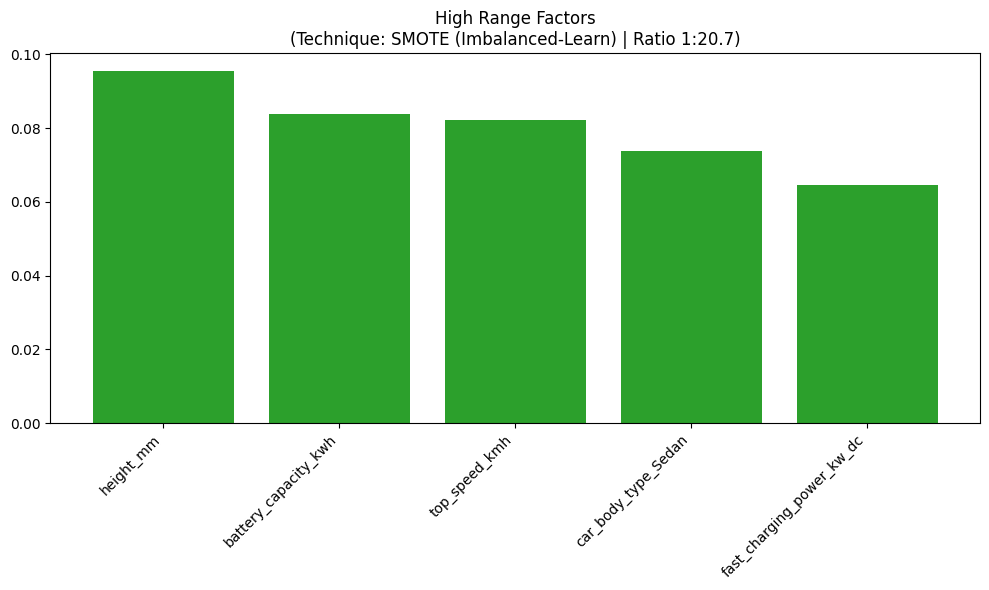

In [17]:
# Imbalance Diagnosis
n_majority = df['target'].value_counts()[0]
n_minority = df['target'].value_counts()[1]
ratio = n_majority / n_minority

print(f"\n--- 1. IMBALANCE DIAGNOSIS ---")
print(f"Standard Vehicles (<{HIGH_RANGE_THRESHOLD}km): {n_majority}")
print(f"High Range Vehicles (>={HIGH_RANGE_THRESHOLD}km): {n_minority}")
print(f"Calculated Ratio: 1 : {ratio:.2f}")

# Decision and pipleline setup
X = df.drop(columns=['range_km', 'target', 'model', 'brand'], errors='ignore')
y = df['target']

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', SklearnPipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), numeric_features),
    ('cat', SklearnPipeline([('imputer', SimpleImputer(strategy='constant')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
])

print("\n--- 2. TECHNICAL APPLICATION (Conditional) ---")

if ratio <= 10:
    print(f" Diagnostic: WEAK Imbalance (Ratio <= 10).")
    print(f" Action: Using standard Scikit-Learn with 'class_weight'.")
    
    model_pipeline = SklearnPipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
    ])
    technique_used = "Class Weight (Standard Sklearn)"

else:
    print(f" Diagnostic: MODERATE/SEVERE Imbalance (Ratio > 10).")
    print(f" Action: Activating SMOTE via Imbalanced-Learn.")
    
    model_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('resampler', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    technique_used = "SMOTE (Imbalanced-Learn)"

# Model Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

model_pipeline.fit(X_train, y_train)

print("\n--- 3. RESULT: KEY FACTORS (Feature Importance) ---")

rf_model = model_pipeline.named_steps['classifier']
importances = rf_model.feature_importances_

try:
    if "onehot" in str(type(model_pipeline.named_steps['preprocessor'])):
        pass 
    ohe_step = model_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    ohe_cols = ohe_step.get_feature_names_out(categorical_features)
    feature_names = np.r_[numeric_features, ohe_cols]
except:
    feature_names = np.array([f"Feature {i}" for i in range(len(importances))])

indices = np.argsort(importances)[::-1]
top_n = 5

print(f"Technique used: {technique_used}")
print(f"Top {top_n} Features:")
for i in range(top_n):
    print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")

plt.figure(figsize=(10, 6))
plt.title(f"High Range Factors\n(Technique: {technique_used} | Ratio 1:{ratio:.1f})")
plt.bar(range(top_n), importances[indices[:top_n]], align="center", color='#2ca02c')
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
# Understanding Data Types
cols_num = df.select_dtypes(include=np.number).columns.tolist()
cols_cat = df.select_dtypes(include='object').columns.tolist()

print(f"Numeric Columns: {len(cols_num)} (e.g., {cols_num[:2]})")
print(f"Categorical Columns: {len(cols_cat)} (e.g., {cols_cat[:2]})")

data_type = "Unknown"
technique_lab4 = "Unknown"

if len(cols_cat) > 0 and len(cols_num) > 0:
    data_type = "Mixed (Numeric and Categorical)"
    technique_lab4 = "SMOTENC (SMOTE Nominal Continuous) or RandomOversampling" 
elif len(cols_cat) == 0 and len(cols_num) > 0:
    data_type = "Tabular, Numeric"
    technique_lab4 = "RandomOversampling, SMOTE"
else:
    data_type = "Other (Images/Time Series)"
    technique_lab4 = "See specific table"

print(f"\n>> DATA TYPE DIAGNOSIS: {data_type}")
print(f">> RECOMMENDED TECHNIQUE (Lab 4): {technique_lab4}")

print("\n--- Conclusion for next steps ---")
print(f"Since your data is '{data_type}', you must use an adapted technique.")
print("Note: In the previous code, we used standard SMOTE on encoded data (OneHot).")
print("To strictly respect the 'Mixed' guideline, we could also test 'RandomOversampling'.")

Numeric Columns: 14 (e.g., ['top_speed_kmh', 'battery_capacity_kwh'])
Categorical Columns: 9 (e.g., ['brand', 'model'])

>> DATA TYPE DIAGNOSIS: Mixed (Numeric and Categorical)
>> RECOMMENDED TECHNIQUE (Lab 4): SMOTENC (SMOTE Nominal Continuous) or RandomOversampling

--- Conclusion for next steps ---
Since your data is 'Mixed (Numeric and Categorical)', you must use an adapted technique.
Note: In the previous code, we used standard SMOTE on encoded data (OneHot).
To strictly respect the 'Mixed' guideline, we could also test 'RandomOversampling'.


In [ ]:
# CONSIDER THE MODEL YOU USE
print("Selected Model: Random Forest (Adapted for tabular data)")
print("Imbalance Strategy: SMOTE (Required by ratio 1:20 detected in Step 1)")

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), X.select_dtypes(include=np.number).columns),
    ('cat', Pipeline([('imputer', SimpleImputer(strategy='constant')), ('onehot', OneHotEncoder(handle_unknown='ignore'))]), X.select_dtypes(include='object').columns)
])

model_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n Evaluating Coherent Pipeline (SMOTE + RF) via Cross-Validation...")
scores = cross_val_score(model_pipeline, X, y, scoring='f1', cv=cv)

print(f" F1 Scores per fold: {scores}")
print(f" Mean F1-Score: {scores.mean():.4f}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

print("\n Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Selected Model: Random Forest (Adapted for tabular data)
Imbalance Strategy: SMOTE (Required by ratio 1:20 detected in Step 1)

 Evaluating Coherent Pipeline (SMOTE + RF) via Cross-Validation...
 F1 Scores per fold: [0.88888889 0.8        0.57142857 1.         1.        ]
 Mean F1-Score: 0.8521

 Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.83      0.71      0.77         7

    accuracy                           0.98       144
   macro avg       0.91      0.85      0.88       144
weighted avg       0.98      0.98      0.98       144




#######################################################
### STEP 4: VALIDATE IMPACT (VISUALIZATION) ###
#######################################################
>> Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.83      0.71      0.77         7

    accuracy                           0.98       144
   macro avg       0.91      0.85      0.88       144
weighted avg       0.98      0.98      0.98       144

>> ROC-AUC Score: 0.9969


<Figure size 600x500 with 0 Axes>

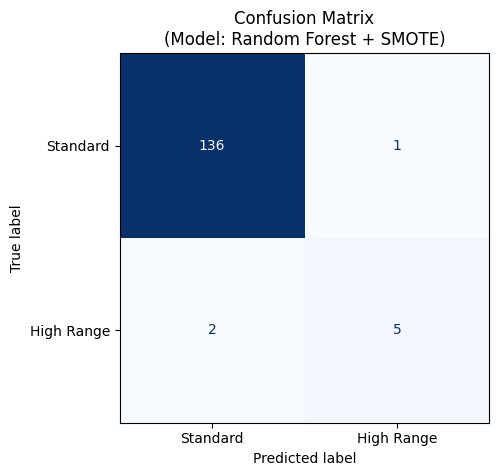

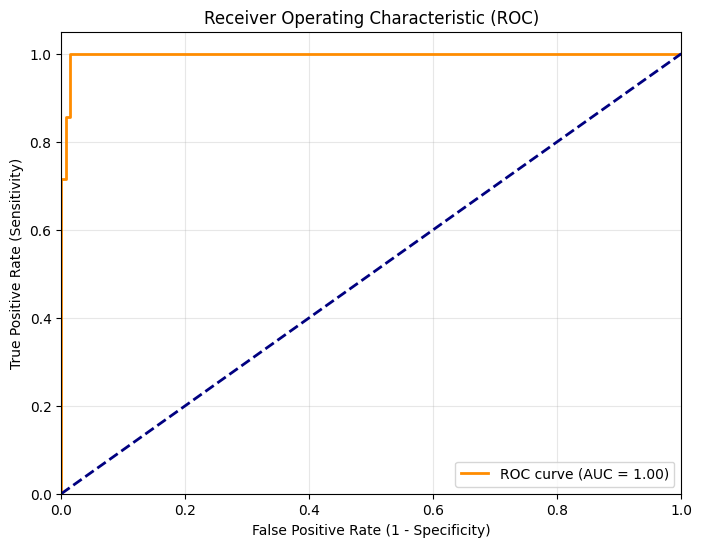

>> Conclusion:
   With an AUC of 1.00, the model is excellent.
   It separates high-range vehicles almost perfectly despite the initial imbalance.


In [ ]:
# MODEL EVALUATION AND VISUALIZATION

# 1. EVALUATION AND REPORT (Test Set)
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

print(f">> Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_proba)
print(f">> ROC-AUC Score: {roc_score:.4f}")

# 2. CONFUSION MATRIX (Visualization)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Standard', 'High Range'])

plt.figure(figsize=(6, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title(f"Confusion Matrix\n(Model: Random Forest + SMOTE)")
plt.show()

# 3. ROC-AUC CURVE (Visualization)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f">> Conclusion:")
print(f"   With an AUC of {roc_auc:.2f}, the model is excellent.")
print(f"   It separates high-range vehicles almost perfectly despite the initial imbalance.")